In [1]:
import voltron 
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

import argparse
import datetime
import gpytorch
from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_gpytorch_torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import SpectralMixtureKernel, MaternKernel, RBFKernel, ScaleKernel
from voltron.means import EWMAMean, DEWMAMean, TEWMAMean, MeanRevertingEMAMean
from voltron.train_utils import LearnGPCV, TrainVolModel, TrainVoltMagpieModel, TrainBasicModel
from voltron.models import VoltMagpie
from voltron.means import LogLinearMean
from voltron.data import make_ticker_list, DataGetter, GetStockHistory

import copy

sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 2.0})

Warning no robinhood utils.


In [2]:
torch.arange(400, 450, 3.)[0]

tensor(400.)

In [3]:
import torch
import gpytorch
from gpytorch.utils.cholesky import psd_safe_cholesky
from gpytorch.utils.cholesky import psd_safe_cholesky

def GeneratePrediction(train_x, train_y, test_x, pred_vol, model, latent_mean=None, theta=0.5):
    vol = model.log_vol_path.exp()
    if model.train_x.ndim != test_x.ndim:
        test_x_for_stack = test_x.unsqueeze(0).repeat(model.train_x.shape[0], 1)
    else:
        test_x_for_stack = test_x
    if vol.ndim == 1:
        vol_for_stack = vol.unsqueeze(0).repeat(pred_vol.shape[0], 1)
    else:
        vol_for_stack = vol

    full_x = torch.cat((model.train_x, test_x_for_stack),dim=-1)
    # print("vol stack = ", vol_for_stack.shape)
    # print("pred_vol = ", pred_vol.shape)
    full_vol = torch.cat((vol_for_stack, pred_vol),dim=-1)

    test_x.repeat(2, test_x.numel())

    idx_cut = model.train_x.shape[-1]
    
    cov_mat = model.covar_module(full_x.unsqueeze(-1), full_vol.unsqueeze(-1)).evaluate()
    K_tr = cov_mat[..., :idx_cut, :idx_cut]
    K_tr_te = cov_mat[..., :idx_cut, idx_cut:]
    K_te = cov_mat[..., idx_cut:, idx_cut:]

    train_mean = model.mean_module(model.train_x)
    train_diffs = model.train_y.unsqueeze(-1) - train_mean.unsqueeze(-1)
    # use psd cholesky if you must evaluate
    K_tr_chol = psd_safe_cholesky(K_tr, jitter=1e-4)
    pred_mean = K_tr_te.transpose(-1, -2).matmul(torch.cholesky_solve(train_diffs, K_tr_chol))
    # print(voltron.mean_module(test_x).detach().T.shape)
    # print(pred_mean.shape)
    pred_mean += model.mean_module(test_x).detach().T.unsqueeze(-1)
    
    if latent_mean is not None:
        pred_mean -= theta * (pred_mean - latent_mean)

    pred_cov = K_te - K_tr_te.transpose(-1, -2).matmul(torch.cholesky_solve(K_tr_te, K_tr_chol))

    pred_cov_L = psd_safe_cholesky(pred_cov, jitter=1e-4)
    samples = torch.randn(*cov_mat.shape[:-2], test_x.shape[0], 1).to(test_x.device)
    samples = pred_cov_L @ samples

    if pred_mean.ndim == 1:
        return samples + pred_mean.unsqueeze(-1)
    else:
        return (samples + pred_mean).squeeze(-1)
    


def Rollouts(train_x, train_y, test_x, model, nsample=50, method = "volt", theta=0.5):
    if method != "volt":
        return nonvol_rollouts(train_x, train_y, test_x, model, nsample=nsample)
    latent_mean = train_y.log().mean()
    ntest = test_x.numel()
    samples = torch.zeros(nsample, ntest)
    pred_vol = model.vol_model(test_x).sample(torch.Size((nsample, ))).exp()
    samples[:, 0] = GeneratePrediction(train_x, train_y, 
                                       test_x[0].unsqueeze(0), 
                                       pred_vol[:, 0].unsqueeze(1),
                                      model, latent_mean, theta).squeeze()
    train_stack_y = train_y[1:].log().repeat(nsample, 1)
    train_stack_vol = model.log_vol_path.repeat(nsample, 1)
    
    for idx in range(1, ntest):
        stack_y = torch.cat((train_stack_y, 
                             samples[:, :idx].to(train_stack_y.device)), -1)
        stack_vol = torch.cat((train_stack_vol, 
                               pred_vol[:, :idx].to(train_stack_vol.device).log()), -1)

        rolling_x = torch.cat((train_x, test_x[:idx]))
        model.mean_module.train_y = stack_y
        model.mean_module.train_x = rolling_x
        
        model.train_x = rolling_x
        model.train_y = stack_y
        model.log_vol_path = stack_vol
        samples[:, idx] = GeneratePrediction(train_x, train_y, 
                                             test_x[idx].unsqueeze(0), 
                                           pred_vol[:, idx].unsqueeze(-1),
                                            model, latent_mean, theta).squeeze()
    return samples, pred_vol


In [4]:
# dat = pd.read_csv("https://www.ncei.noaa.gov/data/local-climatological-data/access/2003/01001099999.csv")
dat = pd.read_csv("https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/2020/CRNS0101-05-2020-AZ_Tucson_11_W.txt",
                 header=None)
dat = dat.iloc[:700]
wind = []
for row, vec in dat.iterrows():
    wind.append(float(vec.item().split()[-2]))

In [5]:
ntrain = 500

train_x = torch.arange(ntrain+1).float()
train_y = torch.FloatTensor(wind[:ntrain]) + 1
test_x = torch.arange(ntrain, len(wind)).float()
test_y = torch.FloatTensor(wind[ntrain:]) + 1

# if torch.cuda.is_available():
#     use_cuda = True,
#     train_x, train_y = train_x.cuda(), train_y.cuda()
#     test_x, test_y = test_x.cuda(), test_y.cuda()

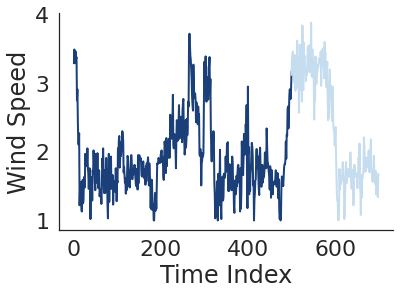

In [6]:
plt.plot(train_x[1:], train_y)
plt.plot(test_x, test_y)
plt.ylabel("Wind Speed")
plt.xlabel("Time Index")
sns.despine()

$S(t)$ is response over time (e.g. wind speed, stock price, etc)

$V(t)$ is the volatility of the process

$$
s(t) = \log(S(t)) \textrm{ and } v(t) = \log(V(t))
$$


\begin{equation}\label{eqn: joint-bm}
\begin{aligned}
ds(t) &= \mu_s dt + V(t)dW(t)\\
dv(t) &= -\frac{\sigma^2}{2}dt  + \sigma dZ(t).
\end{aligned}
\end{equation}

In [7]:
ntrain = 500

train_x = torch.arange(ntrain-1).float()/365
train_y = torch.FloatTensor(wind[:ntrain]) + 1
test_x = torch.arange(ntrain, len(wind)).float()/365
test_y = torch.FloatTensor(wind[ntrain:]) + 1

if torch.cuda.is_available():
    use_cuda = True,
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()

In [8]:
train_x.shape

torch.Size([499])

In [9]:
train_y.shape

torch.Size([500])

In [10]:
with gpytorch.settings.max_cholesky_size(2000):
    vol = LearnGPCV(train_x, train_y, train_iters=200,
                        printing=True)
    vmod, vlh = TrainVolModel(train_x, vol, 
                              train_iters=1000, printing=True)
    

/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iter 1/200 - Loss: 17.179
Iter 51/200 - Loss: 2.631
Iter 101/200 - Loss: 2.568
Iter 151/200 - Loss: 2.564
Iter 1/1000 - Loss: 0.817
Iter 51/1000 - Loss: 0.630
Iter 101/1000 - Loss: 0.422
Iter 151/1000 - Loss: 0.202
Iter 201/1000 - Loss: -0.020
Iter 251/1000 - Loss: -0.236
Iter 301/1000 - Loss: -0.436
Iter 351/1000 - Loss: -0.615
Iter 401/1000 - Loss: -0.767
Iter 451/1000 - Loss: -0.888
Iter 501/1000 - Loss: -0.977
Iter 551/1000 - Loss: -1.036
Iter 601/1000 - Loss: -1.070
Iter 651/1000 - Loss: -1.088
Iter 701/1000 - Loss: -1.096
Iter 751/1000 - Loss: -1.099
Iter 801/1000 - Loss: -1.100
Iter 851/1000 - Loss: -1.100
Iter 901/1000 - Loss: -1.100
Iter 951/1000 - Loss: -1.100


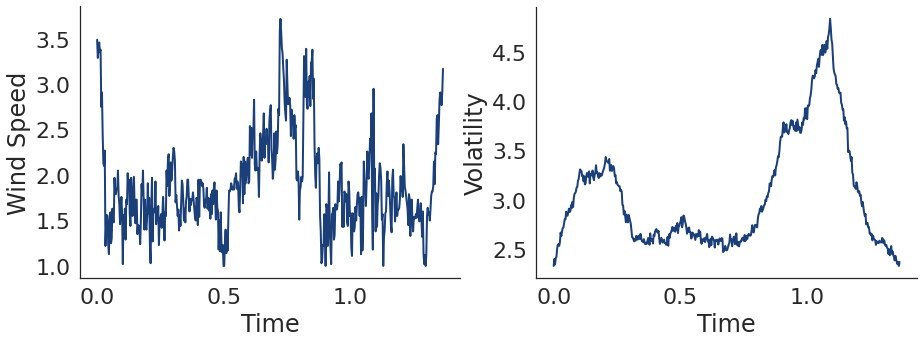

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_x.cpu(), train_y[1:].cpu())
# ax[0].plot(test_x, test_y, color=palette[7])
ax[0].set_ylabel("Wind Speed")
ax[0].set_xlabel("Time")

ax[1].plot(train_x.cpu(), vol.cpu())
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
sns.despine()

In [21]:
voltron, lh = TrainVoltMagpieModel(train_x, train_y[1:], 
                                   vmod, vlh, vol,
                                   printing=True, 
                                   train_iters=100,
                                   k=200, mean_func="constant", theta=0.75)

Iter 1/100 - Loss: 0.859
Iter 51/100 - Loss: -0.401


In [28]:
vmod.eval();
voltron.eval();
voltron.vol_model.eval();
thetas = [0., 0.01, 0.5]
full_samples = torch.zeros(len(thetas), 10, 200)
for theta_idx, theta in enumerate(thetas):
    temp_model = copy.deepcopy(voltron)
    
    with torch.no_grad():
        save_samples, pred_vol = Rollouts(train_x, train_y, test_x, temp_model, 
                                nsample=10, theta=theta)
        full_samples[theta_idx, ...] = save_samples
    torch.cuda.empty_cache()

In [11]:
# pred_vol = vmod(test_x).sample(torch.Size((100, ))).exp()
# predictions = save_samples.exp().detach()

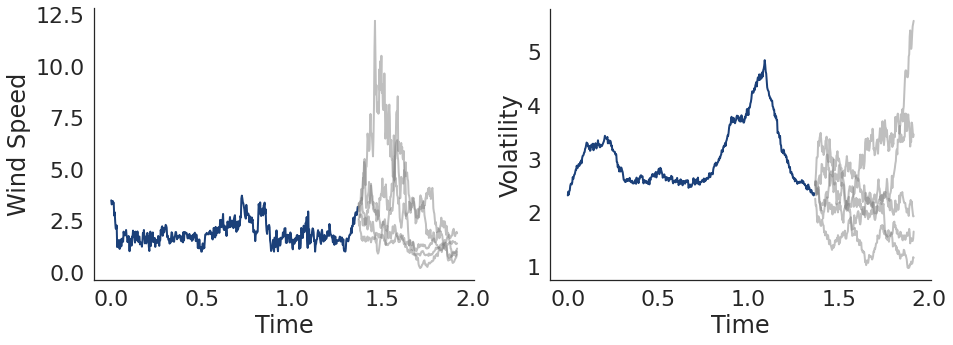

In [35]:
plt_idx = 3
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_x.cpu(), train_y[1:].cpu())
ax[0].plot(test_x.cpu(), full_samples[1, :5].T.exp().cpu(), color='gray', alpha=0.5)
# ax[0].plot(test_x, test_y, color=palette[7])
ax[0].set_ylabel("Wind Speed")
ax[0].set_xlabel("Time")

ax[1].plot(train_x.cpu(), vol.cpu())
ax[1].plot(test_x.cpu(), pred_vol[:5].T.cpu(), color='gray', alpha=0.5)
# ax[1].plot(test_x, pred_vol.mean(0))
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
sns.despine()

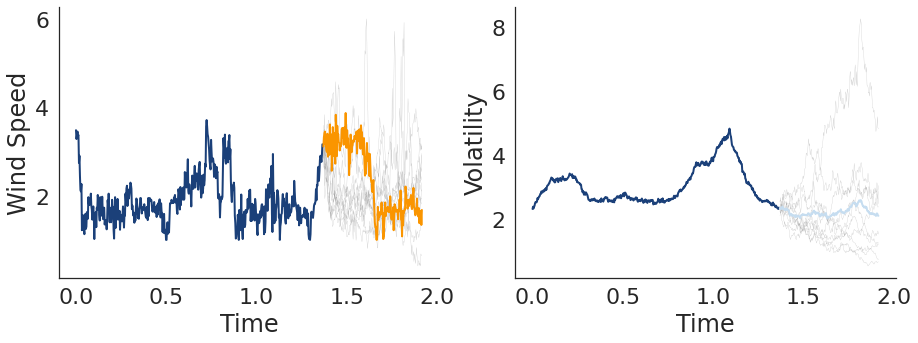

In [14]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_x.cpu(), train_y[1:].cpu())
ax[0].plot(test_x.cpu(), save_samples.T.exp().cpu(), color='gray', lw=0.25, alpha=0.5)
ax[0].plot(test_x.cpu(), test_y.cpu(), color=palette[7])
ax[0].set_ylabel("Wind Speed")
ax[0].set_xlabel("Time")

ax[1].plot(train_x.cpu(), vol.cpu())
ax[1].plot(test_x.cpu(), pred_vol.T.cpu(), color='gray', lw=0.25, alpha=0.5)
ax[1].plot(test_x.cpu(), pred_vol.mean(0).cpu())
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
sns.despine()